In [1]:
# importing 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score,classification_report
from sklearn.feature_selection import chi2
import pickle
nltk.download('stopwords')
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hseth\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
data_loc = "data/Reviews.csv"

In [3]:
df = pd.read_csv(data_loc)

In [4]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


as we are only interested in the text sentiment analysis we can remove all the other columns from our dataset as they won't effect our model

total number of reviews in the dataset is "568454". training the model using that much values will take lot of time 

In [5]:
df = df[:10000] # taking only top 10K 
df.shape

(10000, 10)

#  Text Cleaning / Preprocessing of data

In [7]:
corpus = []
for i in range(0 , 10000):
    review = re.sub('[^a-zA-Z]',' ',df['Text'][i])
    review = review.lower() # converting to lower
    review = review.split() # spliting words
    ps = PorterStemmer() # stemming api to remove ing,es,s etc
    review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))]
    review = ' '.join(review) # recreating sentence using processed words
    corpus.append(review)

In [8]:
corpus = pd.DataFrame(corpus,columns=['Reviews'])
corpus.head()

,Reviews
0,bought sever vital can dog food product found ...
1,product arriv label jumbo salt peanut peanut a...
2,confect around centuri light pillowi citru gel...
3,look secret ingredi robitussin believ found go...
4,great taffi great price wide assort yummi taff...


In [9]:
# joining o/p
results = corpus.join(df[['Score']])
results.head()

,Reviews,Score
0,bought sever vital can dog food product found ...,5
1,product arriv label jumbo salt peanut peanut a...,1
2,confect around centuri light pillowi citru gel...,4
3,look secret ingredi robitussin believ found go...,2
4,great taffi great price wide assort yummi taff...,5


In [10]:
tfidf = TfidfVectorizer()
tfidf.fit(results['Reviews']) # gives multiplication TF and IDF of word

# higher the value rarer the word 

TfidfVectorizer()

In [11]:
# how tfidf works 
x = tfidf.transform(results['Reviews'])
print(results['Reviews'][1])
print(x[1,tfidf.vocabulary_['peanut']])
print(x[1,tfidf.vocabulary_['jumbo']])

product arriv label jumbo salt peanut peanut actual small size unsalt sure error vendor intend repres product jumbo
0.37509695630835344
0.5727828521365451


In [12]:
# now for sentiment analysis we are going to use score and convert to pos or neg
results.dropna(inplace=True)
results[results['Score']!=3] # taking non neutral reviews
results['Positivity'] = np.where(results['Score'] > 3,1,0)
results.drop(['Score'], axis = 1, inplace = True)
results.head()

,Reviews,Positivity
0,bought sever vital can dog food product found ...,1
1,product arriv label jumbo salt peanut peanut a...,0
2,confect around centuri light pillowi citru gel...,1
3,look secret ingredi robitussin believ found go...,0
4,great taffi great price wide assort yummi taff...,1


In [13]:
results.groupby('Positivity').size()

Positivity
0    2384
1    7616
dtype: int64

In [14]:
# splitting of data
X = results.Reviews
y = results.Positivity
Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,random_state = 2)

In [15]:
print("Training data is of size {0}".format(len(Xtrain)))
print("Testing data is of size {0}".format(len(Xtest)))

Training data is of size 7500
Testing data is of size 2500


In [16]:
# first using random forest machine learning algo to make the predictions 

In [17]:
def accurcay_all(pipeline, xtrain,ytrain,xtest,ytest):
    sentiment_fit = pipeline.fit(xtrain,ytrain)
    ypred = sentiment_fit.predict(xtest)
    accuracy = accuracy_score(ytest,ypred)
    print("accuracy score is : {0:.2f}%".format(accuracy*100))
    return accuracy

In [18]:
cv = CountVectorizer() # we can use different vectorizer
randomforest = RandomForestClassifier(class_weight = "balanced")
n_features = np.arange(10000,25001,5000) # value between 10K and 25K with 5K gaps
def feature_accuracy_check(vectorizer = cv,n_features =n_features,stop_words= None,ngram_range=(1,1),classifier = randomforest):
    result = []
    for n in n_features:
        vectorizer.set_params(stop_words = stop_words,max_features = n,ngram_range=ngram_range)
        checker_pipeline = Pipeline([
            ('vectorizer',vectorizer),
            ('classifier',classifier)
        ])
        print("test results for {} features".format(n))
        nfeature_acc = accurcay_all(checker_pipeline,Xtrain,ytrain,Xtest,ytest)
        result.append((n,nfeature_acc))
    return result

In [19]:
# using tfidf as vectorizer just to get the hyperparameter that is n_features
tfidf = TfidfVectorizer()

In [20]:
print("Using TFIDF vectorization")
feature_result = feature_accuracy_check(vectorizer=tfidf,ngram_range=(1,3))
# ngram_range = (1,3) means we can use uni-gram, bi-gram,tri-gram

Using TFIDF vectorization
test results for 10000 features
accuracy score is : 85.56%
test results for 15000 features
accuracy score is : 84.88%
test results for 20000 features
accuracy score is : 84.28%
test results for 25000 features
accuracy score is : 84.92%


In [23]:
cv = CountVectorizer(max_features=30000,ngram_range=(1,3))
pipeline = Pipeline([
    ('vectorizer',cv),
    ('classifier',randomforest)
])
sentiment_fit = pipeline.fit(Xtrain,ytrain)
ypred = sentiment_fit.predict(Xtest)

print(classification_report(ytest,ypred,target_names=["negative","positive"]))

              precision    recall  f1-score   support

    negative       0.90      0.36      0.51       572
    positive       0.84      0.99      0.91      1928

    accuracy                           0.84      2500
   macro avg       0.87      0.67      0.71      2500
weighted avg       0.85      0.84      0.82      2500



In [25]:
# KFold 
accuracies = cross_val_score(estimator=pipeline,X =Xtrain,y=ytrain,cv=10)
print("RandomForest Classifier accuracy:{0}%".format(accuracies.mean()*100))

RandomForest Classifier accuracy:83.02666666666667%


In [26]:
# chi2 Feature Selection
tfidf = TfidfVectorizer(max_features=30000,ngram_range=(1,3))
x_tfidf = tfidf.fit_transform(results.Reviews)
y = results.Positivity
chi2score = chi2(x_tfidf,y)[0]

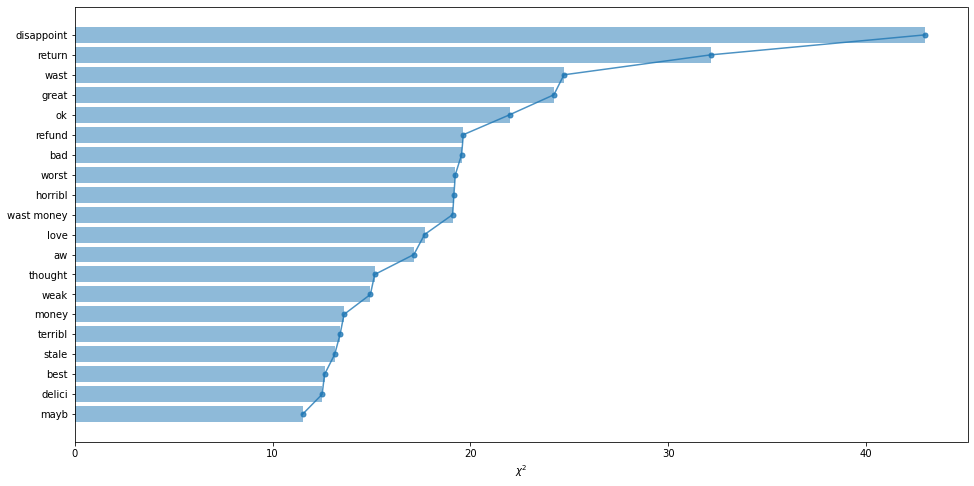

In [27]:
plt.figure(figsize=(16,8))
scores = list(zip(tfidf.get_feature_names(),chi2score))
chi2 =sorted(scores,key=lambda x:x[1])
topchi2 = list(zip(*chi2[-20:]))
x = range(len(topchi2[1]))
labels = topchi2[0]
plt.barh(x,topchi2[1],align='center',alpha=0.5)
plt.plot(topchi2[1],x,'-o',markersize = 5,alpha =0.8)
plt.yticks(x,labels)
plt.xlabel('$\chi^2$')
plt.show()